In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from yolov1 import YOLO1, YoloLoss, non_max_suppression
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
import matplotlib.patches as patches

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class VOCDataset(Dataset):
    
    def __init__(self, path, file, S=7, C=20, imagesize=448):
        
        self.data = pd.read_csv(os.path.join(path, file), header=None).values
        self.sample_path = os.path.join(os.path.join(path, 'images'))
        self.label_path = os.path.join(os.path.join(path, 'labels'))
        labelname_file = open(os.path.join(path,'labelnames.txt'), "r") 
        names = labelname_file.readlines() 
        labelname_file.close()
        self.labelnames = list(map(lambda x:x.split('\n')[0], names))
        self.S = S
        self.C = C
        self.imagesize = imagesize
    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self,index):
        
        img = Image.open(os.path.join(self.sample_path, self.data[index,0]))
        img = img.resize((self.imagesize,self.imagesize))
        sample = np.asanyarray(img)
        sample = sample/255
        sample = torch.tensor(np.transpose(sample, (2,0,1)), dtype=torch.float)
        label_raw = np.loadtxt(os.path.join(self.label_path, self.data[index,1]))
        if len(label_raw.shape)==1:
            label_raw = label_raw.reshape(1,5)
        label = torch.zeros((self.S, self.S, self.C + 5))

        for n in range(len(label_raw)):
            c = int(label_raw[n,0])
            loc = (self.S*label_raw[n,1:3]).astype(int)
            box_center = self.S*label_raw[n,1:3] - loc
            box_size = self.S*label_raw[n,3:5]
            box = torch.tensor(np.concatenate((box_center, box_size)), dtype=torch.float)
            label[loc[1], loc[0], c] = 1
            label[loc[1], loc[0], self.C] = 1
            label[loc[1], loc[0], self.C+1:] = box

        
        return sample, label

In [3]:
def plot_boxes(boxes, width, height, ax, color="r"):
    
    for box in boxes:
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor=color,
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
    return ax

In [4]:
def plot_prediction(dataset, model, idx, iou_threshold=0.5, threshold=0.5):
    
    labelnames = np.array(dataset.labelnames)
    C = len(labelnames)
    x = dataset[idx][0]
    y = dataset[idx][1]
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    y_pred = model(x)
    image = np.transpose(x.numpy()[0,:,:,:], (1,2,0))
    width = image.shape[0]
    height = image.shape[1]
    true_boxes = non_max_suppression(y, iou_threshold, threshold, C)
    true_classes = []
    pred_boxes = non_max_suppression(y_pred, iou_threshold, threshold, C)
    pred_classes = []

    fig, ax = plt.subplots()
    ax.imshow(image)
    for n in range(C):
        if true_boxes[n]:
            true_classes.append(n)
            ax=plot_boxes(true_boxes[n], width, height, ax, color='r') 
        if pred_boxes[n]:
            pred_classes.append(n)
            ax=plot_boxes(pred_boxes[n], width, height, ax, color='g') 
    print('true classes: '+', '.join(list(labelnames[true_classes])))
    print('predicted classes: '+', '.join(list(labelnames[pred_classes])))

# Setup the datasets

In [5]:
path_data = './data/PascalVOC_YOLO/'

batch_size = 16

train_dataset = VOCDataset(path_data, 'train.csv', imagesize=448)

test_dataset = VOCDataset(path_data, 'test.csv', imagesize=448)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

# Network Architecture

-[source #1](https://arxiv.org/abs/1506.02640)

-[source #2](https://www.youtube.com/watch?v=n9_XyCGr-MI&list=PLy5rjn5-uSPAKe2PfszYRqNY7JJC45P1d&index=7&t=1920s)

![Alt text](https://www.researchgate.net/publication/330234661/figure/fig1/AS:732961892757504@1551763141028/YOLO-v1-network-structure-Yolo-v2-Tiny-has-fewer-parameters-than-Yolo-v1-Its-network.jpg "Architecture")

In [6]:
cnn_architecture = []

element_1 = {'type': 'cnn_block',
             'layers':[{'cout':64,
                        'kernel_size':7,
                        'padding': 3,
                        'stride':2}],
            'repeat': 1}

cnn_architecture.append(element_1)

element_2 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_2)

element_3 = {'type': 'cnn_block',
             'layers':[{'cout':192,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_3)

element_4 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_4)

element_5 = {'type': 'cnn_block',
             'layers':[{'cout':128,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':256,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1},
                      {'cout':256,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':512,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_5)

element_6 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_6)

element_7 = {'type': 'cnn_block',
             'layers':[{'cout':256,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':512,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 4}

cnn_architecture.append(element_7)

element_8 = {'type': 'cnn_block',
             'layers':[{'cout':512,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_8)

element_9 = {'type': 'maxpool',
             'parameters':{'kernel_size':2,
                           'stride': 2}} 

cnn_architecture.append(element_9)

element_10 = {'type': 'cnn_block',
             'layers':[{'cout':512,
                        'kernel_size':1,
                        'padding': 0,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 2}

cnn_architecture.append(element_10)

element_11 = {'type': 'cnn_block',
             'layers':[{'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':2},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1},
                      {'cout':1024,
                        'kernel_size':3,
                        'padding': 1,
                        'stride':1}],
            'repeat': 1}

cnn_architecture.append(element_11)

fc_architecture ={'S':7, 'B':2, 'C':20, 'c_hidden': 496}

# Model training

In [7]:
model = YOLO1(cnn_architecture, fc_architecture)

In [8]:
for (x,y) in train_loader:
    break

In [9]:
x.shape

torch.Size([16, 3, 448, 448])

In [10]:
y.shape

torch.Size([16, 7, 7, 25])

In [11]:
y_pred = model(x)

In [12]:
y_pred.shape

torch.Size([16, 7, 7, 30])

In [13]:
target = y
predictions = y_pred

In [14]:
lossfn = YoloLoss()
lossfn(predictions, target)

tensor(1278.8467, grad_fn=<AddBackward0>)

true classes: bird
predicted classes: 


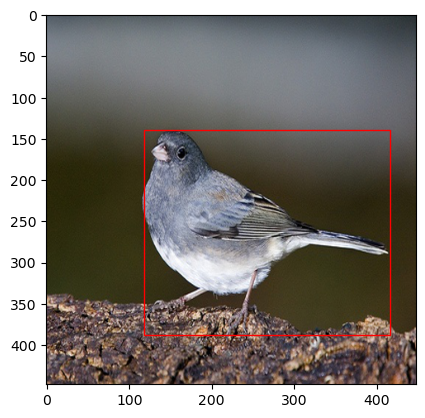

In [19]:
dataset = test_dataset
idx = 74
plot_prediction(dataset, model, idx)